In [85]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

data_3 = "https://github.com/MIDS-at-Duke/opioid-2023-group-8-final-opioid/raw/data_merging/20_Intermediate_Files/Texas_Merged.csv"

tx_and_control_death = pd.read_csv(data_3)

In [86]:
tx_and_control_death["Deaths"].sum()

45420.0

In [87]:
# Dropping rows where there is any NA value
tx_and_control_death_cleaned = tx_and_control_death.dropna()

In [88]:
tx_and_control_death_cleaned.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage
12951,2014,TX,"Dallas County, TX",48113,2519407.0,353.0,4.859420e+08
9865,2008,AR,"Bradley County, AR",5011,11643.0,1.0,2.122822e+06
10562,2009,MO,"Pike County, MO",29163,18544.0,3.0,4.900510e+06
7034,2003,TX,"Lubbock County, TX",48303,253388.0,14.0,0.000000e+00
12586,2013,MN,"Lyon County, MN",27083,25727.0,3.0,3.334074e+06


## Death-per-capita for TX and Control States

In [89]:
# Calculating death_per_capita
tx_and_control_death_cleaned["Death_per_capita"] = (
    tx_and_control_death_cleaned["Deaths"] / tx_and_control_death_cleaned["Population"]
)

In [90]:
death_per = tx_and_control_death_cleaned["Death_per_capita"] * 100000

## Sort out for TX and Control States Separately

In [91]:
# subset the data for only TX
tx_treatment_state = tx_and_control_death_cleaned[
    tx_and_control_death_cleaned["State Code"] == "TX"
]
# subset the data for only the control states
controls = ["MO", "MN", "AR"]
control_states = tx_and_control_death_cleaned[
    tx_and_control_death_cleaned["State Code"].isin(controls)
]

In [92]:
tx_treatment_state.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage,Death_per_capita
8622,2006,TX,"Live Oak County, TX",48297,11559.0,1.0,8.271292e+05,0.000087
10325,2009,TX,"Hood County, TX",48221,50841.0,5.0,1.545815e+07,0.000098
9221,2007,TX,"Deaf Smith County, TX",48117,18916.0,2.0,1.676399e+06,0.000106
9131,2007,TX,"Newton County, TX",48351,14335.0,1.0,3.421161e+06,0.000070
12289,2013,TX,"Atascosa County, TX",48013,47029.0,4.0,1.431547e+07,0.000085


In [93]:
control_states.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage,Death_per_capita
12083,2012,MN,"Dodge County, MN",27039,20273.0,2.0,1.190168e+06,0.000099
10991,2010,MN,"Lake of the Woods County, MN",27077,4035.0,0.0,2.008322e+06,0.000000
9424,2007,MN,"Cook County, MN",27031,5217.0,0.0,8.713568e+05,0.000000
10093,2009,MO,"Webster County, MO",29225,35997.0,5.0,1.233456e+07,0.000139
11020,2010,MN,"Dakota County, MN",27037,399214.0,18.0,7.399955e+07,0.000045


## Plot Diff-in-Diff

In [94]:
sub_tx_treatment_state = tx_treatment_state[
    (tx_treatment_state["Year"] >= 2003) & (tx_treatment_state["Year"] <= 2010)
]

sub_control_states = control_states[
    (control_states["Year"] >= 2003) & (control_states["Year"] <= 2010)
]

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
from matplotlib.lines import Line2D

# specify the years needed before the policy change
year = [2003, 2004, 2005, 2006]
# create new dataframe with only data from those years
pre_TX_death = sub_tx_treatment_state.loc[sub_tx_treatment_state["Year"].isin(year)]
post_TX_death = sub_tx_treatment_state.loc[~sub_tx_treatment_state["Year"].isin(year)]

pre_crtl_death = sub_control_states.loc[sub_control_states["Year"].isin(year)]
post_crtl_death = sub_control_states.loc[~sub_control_states["Year"].isin(year)]

In [96]:
import numpy as np
import statsmodels.formula.api as smf


def get_reg_fit(data, color, yvar, xvar, legend, alpha=0.05):
    years = list(np.arange(2003, 2010, 1))

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    xmin = x.min()
    xmax = x.max()
    step = (xmax - xmin) / 100
    grid = np.arange(xmin, xmax + step, step)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Build chart
    predictions["Treat"] = f"{legend}"

    # Plotting regression line
    plt.plot(predictions[xvar], predictions[yvar], color=color, label=legend)

    # Plotting confidence interval
    plt.fill_between(
        predictions[xvar],
        predictions["ci_low"],
        predictions["ci_high"],
        color=color,
        alpha=0.3,
        label=f"{legend} CI",
    )

    plt.xlabel(xvar)
    plt.ylabel("Death per Capita")

    return predictions

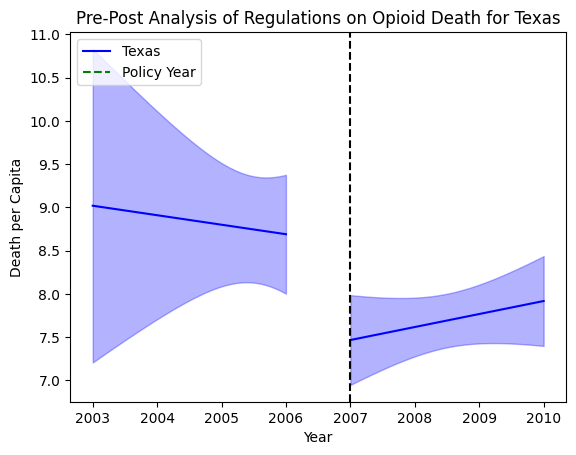

In [97]:
# Create subplots
fig, ax = plt.subplots()

# Scale up the 'Death_per_capita' values by multiplying by 100000
pre_TX_death["Death_per_capita_scaled"] = pre_TX_death["Death_per_capita"] * 100000
post_TX_death["Death_per_capita_scaled"] = post_TX_death["Death_per_capita"] * 100000

# Plot pre_TX_plot
pre_TX_plot = get_reg_fit(
    pre_TX_death, "blue", "Death_per_capita_scaled", "Year", "Texas", alpha=0.05
)

# Plot post_TX_plot
post_TX_plot = get_reg_fit(
    post_TX_death, "blue", "Death_per_capita_scaled", "Year", "Texas", alpha=0.05
)

# Plotting a vertical line for the policy year
ax.axvline(x=2007, color="black", linestyle="--", label="Policy Year")

plt.title("Pre-Post Analysis of Regulations on Opioid Death for Texas")

plt.legend(
    handles=[
        Line2D([0], [0], color="blue", label="Texas"),
        Line2D([0], [0], color="green", linestyle="--", label="Policy Year"),
    ],
    loc="upper left",
)

# Show the plot
plt.savefig("PrePostDeathTexas.png", format="png")
plt.show()

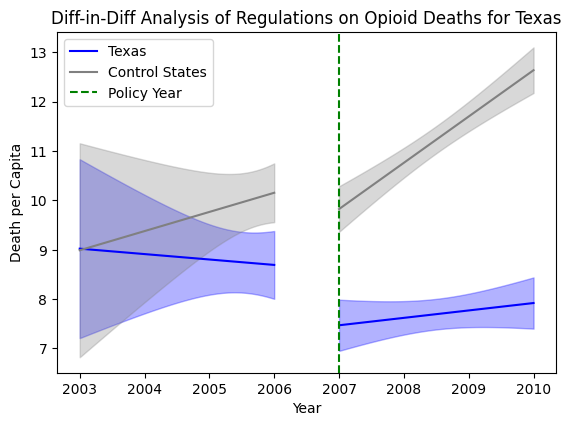

In [98]:
# Plot all data on the same chart
fig, ax = plt.subplots()

# Plot pre_TX_plot
pre_TX_plot = get_reg_fit(
    pre_TX_death, "blue", "Death_per_capita_scaled", "Year", "Texas", alpha=0.05
)

# Plot post_TX_plot
post_TX_plot = get_reg_fit(
    post_TX_death, "blue", "Death_per_capita_scaled", "Year", "Texas", alpha=0.05
)


# Ensure the same scaling is applied to the control states dataframes
pre_crtl_death["Death_per_capita_scaled"] = pre_crtl_death["Death_per_capita"] * 100000
post_crtl_death["Death_per_capita_scaled"] = (
    post_crtl_death["Death_per_capita"] * 100000
)

# Plot pre_crtl_plot
pre_crtl_plot = get_reg_fit(
    pre_crtl_death,
    "grey",
    "Death_per_capita_scaled",
    "Year",
    "Control States",
    alpha=0.05,
)

# Plot post_crtl_plot
post_crtl_plot = get_reg_fit(
    post_crtl_death,
    "grey",
    "Death_per_capita_scaled",
    "Year",
    "Control States",
    alpha=0.05,
)

# Plotting a vertical line for the policy year
ax.axvline(x=2007, color="green", linestyle="--", label="Policy Year")

# Set chart title
plt.title("Diff-in-Diff Analysis of Regulations on Opioid Deaths for Texas")

# Display the legend with more specific labels
plt.legend(
    handles=[
        Line2D([0], [0], color="blue", label="Texas"),
        Line2D([0], [0], color="grey", label="Control States"),
        Line2D([0], [0], color="green", linestyle="--", label="Policy Year"),
    ],
    loc="upper left",
)

# Show the plot
plt.subplots_adjust(left=0.17, right=0.95, top=0.95, bottom=0.24)
plt.savefig("DiffDeathTexas.png", format="png")
plt.show()